In [325]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import matplotlib.pyplot as plt

In [326]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [327]:
train_df.head(n=5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [328]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

In [329]:
def convert_str_to_num(df, column, saved_dict):
    if saved_dict is not None:
        print('using passed entry dict')
        entry_dict = saved_dict
    else:
        print('creating a new entry dict')
        entry_dict = {}
        unique_entries = list(df[column].unique())
        for idx, value in enumerate(unique_entries):
            entry_dict[value if isinstance(value, str) else str(value)] = idx+1
        
    for i in range(len(df)):
        if df[column][i] in entry_dict:
            df[column][i] = entry_dict[df[column][i]]
        else:
            df[column][i] = 0
        
    # for value in entry_dict:
    #  df[column] = df[column].replace(value, entry_dict[value])
    return df, entry_dict

In [330]:
train_df, sex_dict = convert_str_to_num(train_df.copy(), 'Sex', saved_dict=None)
train_df, cabin_dict = convert_str_to_num(train_df.copy(), 'Cabin', saved_dict=None)
train_df, emb_dict = convert_str_to_num(train_df.copy(), 'Embarked', saved_dict=None)

test_df, _ = convert_str_to_num(test_df.copy(), 'Sex', saved_dict=sex_dict)
test_df, _ = convert_str_to_num(test_df.copy(), 'Cabin', saved_dict=cabin_dict)
test_df, _ = convert_str_to_num(test_df.copy(), 'Embarked', saved_dict=emb_dict)

creating a new entry dict


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


creating a new entry dict


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


creating a new entry dict
using passed entry dict
using passed entry dict
using passed entry dict


In [331]:
def normalize_column_min_max(df, column, minimum=None, maximum=None):
    if minimum is None or maximum is None:
        print("creating new min max ")
        minimum = df[column].min()
        maximum = df[column].max()
    else:
        print("using passed values")
    
    df[column] = (df[column]-minimum)/(maximum-minimum)
    return df, minimum, maximum

In [332]:
train_df, p_min, p_max = normalize_column_min_max(df=train_df.copy(), column='Pclass')
train_df, a_min, a_max = normalize_column_min_max(df=train_df.copy(), column='Age')
train_df, c_min, c_max = normalize_column_min_max(df=train_df.copy(), column='Cabin')
train_df, e_min, e_max = normalize_column_min_max(df=train_df.copy(), column='Embarked')

test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='Pclass', minimum=p_min, maximum=p_max)
test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='Age', minimum=a_min, maximum=a_max)
test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='Cabin', minimum=c_min, maximum=c_max)
test_df, _, _ = normalize_column_min_max(df=test_df.copy(), column='Embarked', minimum=e_min, maximum=e_max)

creating new min max 
creating new min max 
creating new min max 
creating new min max 
using passed values
using passed values
using passed values
using passed values


In [333]:
input_columns = ['Pclass', 'Sex', 'Age', 'Cabin', 'Embarked']
_input = []
_labels = []

for _, row in train_df.iterrows():
    input_ = []
    _labels.append([row['Survived']])
    for column in input_columns:
        input_.append(row[column])
    _input.append(input_)

train_length = int(len(_input)*0.9)

train_input, train_labels = _input[:train_length], _labels[:train_length]
val_input, val_labels = _input[train_length:], _labels[train_length:]

In [335]:
train_data = tf.data.Dataset.from_tensor_slices((train_input, train_labels))
val_data = tf.data.Dataset.from_tensor_slices((val_input, val_labels))

In [354]:
model = Sequential()
model.add(layers.Dense(16, input_shape=(5, 1), activation='relu'))
model.add(layers.Dropout(rate=0.5))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [355]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=["accuracy"])

In [356]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_155 (Dense)            (None, 5, 16)             32        
_________________________________________________________________
dropout_32 (Dropout)         (None, 5, 16)             0         
_________________________________________________________________
dense_156 (Dense)            (None, 5, 32)             544       
_________________________________________________________________
dense_157 (Dense)            (None, 5, 128)            4224      
_________________________________________________________________
dense_158 (Dense)            (None, 5, 64)             8256      
_________________________________________________________________
dense_159 (Dense)            (None, 5, 1)              65        
Total params: 13,121
Trainable params: 13,121
Non-trainable params: 0
_________________________________________________

In [357]:
history = model.fit(train_data, validation_data=val_data, epochs=20, batch_size=16)

Epoch 1/20
801/801 [==============================] - 2s 2ms/step - loss: 0.6739 - accuracy: 0.5988 - val_loss: 0.6640 - val_accuracy: 0.6222
Epoch 2/20
801/801 [==============================] - 1s 2ms/step - loss: 0.6619 - accuracy: 0.6292 - val_loss: 0.6652 - val_accuracy: 0.6222
Epoch 3/20
801/801 [==============================] - 1s 2ms/step - loss: 0.6521 - accuracy: 0.6409 - val_loss: 0.6654 - val_accuracy: 0.6222
Epoch 4/20
801/801 [==============================] - 1s 2ms/step - loss: 0.6465 - accuracy: 0.6429 - val_loss: 0.6678 - val_accuracy: 0.6222
Epoch 5/20
801/801 [==============================] - 1s 2ms/step - loss: 0.6458 - accuracy: 0.6457 - val_loss: 0.6739 - val_accuracy: 0.6222
Epoch 6/20
801/801 [==============================] - 2s 2ms/step - loss: 0.6435 - accuracy: 0.6459 - val_loss: 0.6787 - val_accuracy: 0.6222
Epoch 7/20
801/801 [==============================] - 1s 2ms/step - loss: 0.6426 - accuracy: 0.6494 - val_loss: 0.6709 - val_accuracy: 0.6222
Epoch 

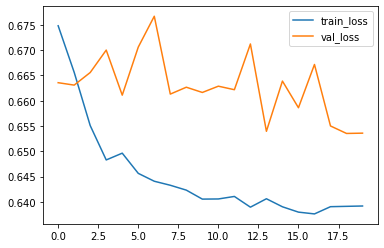

In [348]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

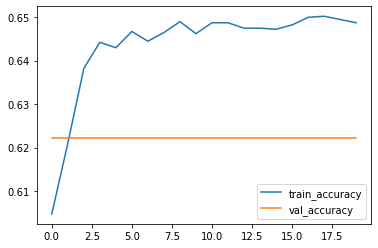

In [349]:
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [ ]:
test_df

for _, row in test_df.iterrows():
    input_ = []
    for column in input_columns:
        input_.append(row[column])
    input_ = np.array(input_)
    input_ = input_.reshape()
    print(input_.shape)
    print(model.predict(input_))